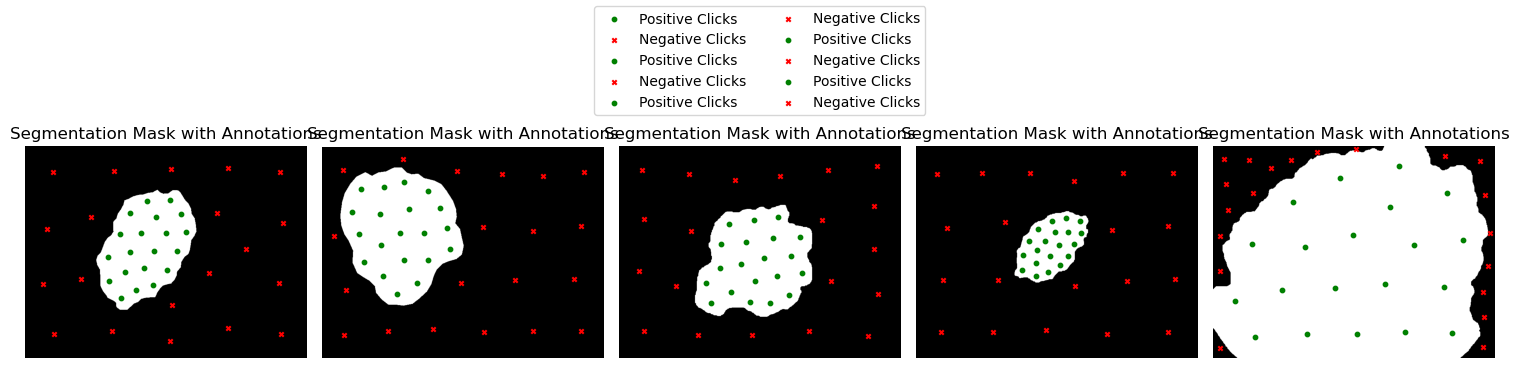

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.cluster import KMeans

# %% [markdown]
# ### Strategy 1: 
# 1. Extract positive and negative pixels.
# 2. Randomly sample the required number of clicks.

# %%
import os
import glob
import random
from PIL import Image
import torch
from torch.utils.data import Dataset

class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np, num_points=20):
        # Cluster-Based Sampling Strategy
        
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        # Positive Clicks - use clustering to find representative points
        if len(positive_pixels) > num_points:
            kmeans_positive = KMeans(n_clusters=num_points, random_state=42)
            kmeans_positive.fit(positive_pixels)
            positive_points = kmeans_positive.cluster_centers_.astype(int)
        else:
            # If there are fewer positive pixels than the required number of points, sample them all
            positive_points = positive_pixels

        # Negative Clicks - use clustering to find representative points
        if len(negative_pixels) > num_points:
            kmeans_negative = KMeans(n_clusters=num_points, random_state=42)
            kmeans_negative.fit(negative_pixels)
            negative_points = kmeans_negative.cluster_centers_.astype(int)
        else:
            # If there are fewer negative pixels than the required number of points, sample them all
            negative_points = negative_pixels
        
        return positive_points, negative_points

# Usage
data_path = "/dtu/datasets1/02516//PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()             # Convert to tensor
])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')

# Optional: Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

def display_mask_with_annotations(dataset, n_samples=5):
    sampled_indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        # Get image, label, and points
        image, label, pos_points, neg_points = dataset[idx]

        # The label is already in NumPy format, no need to convert
        # Plot segmentation mask with positive and negative points overlaid
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', label='Positive Clicks', marker='o', s=10)  # Plot positive points
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', label='Negative Clicks', marker='x', s=10)  # Plot negative points
        plt.title("Segmentation Mask with Annotations")
        plt.axis("off")

    # Adding a legend for the entire figure (only once)
    plt.figlegend(loc='upper center', ncol=2)
    plt.tight_layout()
    plt.show()

# Display masks with positive and negative points from the training dataset
display_mask_with_annotations(train_dataset, n_samples=5)


The Cluster-Based Sampling Strategy uses K-means clustering to identify representative regions for both positive and negative clicks:

Positive Clicks: Points are sampled using clustering within the lesion area, ensuring that the selection represents the diversity within the lesion, simulating how a user might choose key points covering the entire lesion.

Negative Clicks: Points are sampled using clustering within the background area, making sure that representative points from different regions of the background are chosen to cover a broad range of negative samples.

This method ensures that the weak annotations are well-distributed, capturing diverse areas of both the lesion and the background for effective training.